
# CIFAR-10 Image Classification With CNN 

In this notebook, I will explore image classification using two different deep learning models.
A simple convolutional neural network (CNN) and a more advanced model based on the ResNet50 architecture.
My task will be to classify images from the CIFAR-10 dataset.
## Training
- Data preparation
- Data augementation
- Hyper parameter tuning
- Defining the models
- Compiling the models
- Training the models
- Saving the models
## Evaluation
- Loading the saved models
- Evaluating the models on the test set
- Generating classification reports
- Creating confusion matrices
Plotting the training and validation curves
## Comparison
- Comparing the performance of the models on various metrics
- Analyzing the strengths and weaknesses of each model
- Interpreting the results and drawing conclusions
## Final Thoughts
 - My thoughts on the task of image classification
 - A summary of the results achieved by the models
-  Reflections on model selection and the trade-offs between model complexity and performance

### Imports

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization ,UpSampling2D
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, InceptionV3
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os

## Loading  Data Set  
Here , I will load  [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes dataset using Keras 

In [4]:
# Load the CIFAR-10 dataset

(x_train_, y_train_), (x_test_, y_test_) = cifar10.load_data()

### Visualize Few Images From the dataset
Here I will Use the `show_images` function to view some of the images and their class labels.

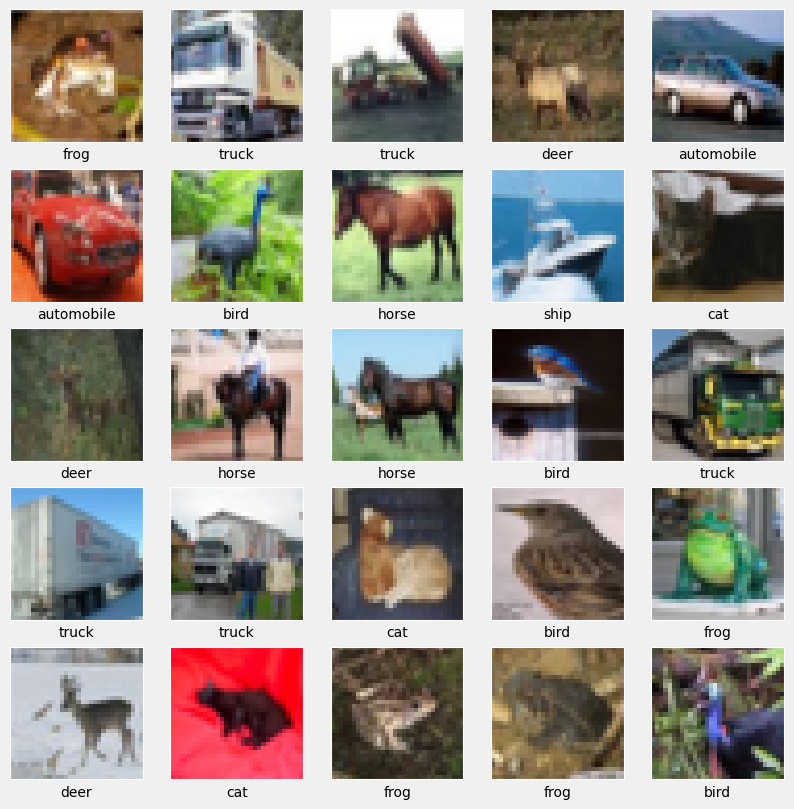

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
def show_images ():
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train_[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[y_train_[i][0]])
    plt.show()
    
show_images()

## Parameters
Here I will Define parameters and some variables like batch size, epochs and number of classes 

In [6]:
batch_size = 128
epochs = 50
num_classes = 10


### Preprocess Dataset
Here, I will perform normalization of  images in training and validation data set and 
Convert the labels to one-hot encoding


In [55]:
x_train = x_train_.astype('float32') / 255.0
x_test = x_test_.astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train_, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_, num_classes)


### Data Augmentation
Here , I will apply Data augmentation on training data
 to improve the robustness and generalization of our models

In [48]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

## Model Architectures
- Simple CNN Model Architecture
- ResNet50 Model Architecture

Here,I will define and describe the architecture of the two deep learning models used for image classification on the CIFAR-10 dataset.




### Simple CNN Model Architecture
For this architecture, I have used a simple CNN to train the model from scratch. The model consists of multiple convolutional layers with batch normalization, max pooling, and dropout layers, followed by dense layers. The activation function used for all convolutional layers is ReLU, while the output layer uses a softmax activation function.
# Note
### The reason why I am using two different CNN architectures and their comparison will be discussed in the 'Comparison  Models Section', where I will analyze the strengths and weaknesses of each model and interpret the results to draw conclusions.


In [49]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


## Compiling The Model
After defining the model architecture, the next step is to compile the model by specifying the optimizer, loss function, and evaluation metric. This is done using the compile method of the Sequential model in Keras.

In [50]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/Users/akhtarali/miniconda3/envs/dl-practice/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Save Checkpoints During Training
To save the model weights at various checkpoints during training, we can use the ModelCheckpoint callback provided by Keras. This can help us to resume training from a previously saved checkpoint, in case training gets interrupted or we want to experiment with different hyperparameters
( I have tried multiple hyperparameter tunings , which I will disscuss later section)

In [51]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Hyperparameter Tuning
In this section, I will apply a learning rate schedule to the model, which reduces the learning rate as the epoch increases. The function scheduler() is defined to schedule the learning rate at different epochs.

In [10]:
# Learning rate schedule
def scheduler(epoch):
  if epoch < 30:
    return 0.001
  elif epoch < 50:
    return 0.0001
  else:
    return 0.00001

## Train The Model
This section trains the defined CNN model using the data generated from the data augmentation section. It also sets a learning rate scheduler to adjust the learning rate during training. If a saved checkpoint is available, it loads the weights from the last saved checkpoint.

In [11]:
lr_scheduler = LearningRateScheduler(scheduler)
callbacks_list = [lr_scheduler,checkpoint]

# Load the weights from the last saved checkpoint, if available
if os.path.exists(filepath):
    model.load_weights(filepath)

    
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / 128,
                    epochs= epochs,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list)

Epoch 1/50


2023-04-02 05:01:23.356830: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-02 05:01:23.679211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/390 [==============================] - ETA: 0s - loss: 1.8396 - accuracy: 0.3680

2023-04-02 05:01:46.782559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.25120, saving model to weights-improvement-01-0.25.hdf5
390/390 [==============================] - 26s 65ms/step - loss: 1.8396 - accuracy: 0.3680 - val_loss: 2.4026 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 2/50
391/390 [==============================] - ETA: 0s - loss: 1.3056 - accuracy: 0.5339
Epoch 2: val_accuracy improved from 0.25120 to 0.57090, saving model to weights-improvement-02-0.57.hdf5
390/390 [==============================] - 25s 64ms/step - loss: 1.3056 - accuracy: 0.5339 - val_loss: 1.2259 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 3/50
391/390 [==============================] - ETA: 0s - loss: 1.0958 - accuracy: 0.6123
Epoch 3: val_accuracy improved from 0.57090 to 0.62860, saving model to weights-improvement-03-0.63.hdf5
390/390 [==============================] - 25s 64ms/step - loss: 1.0958 - accuracy: 0.6123 - val_loss: 1.0562 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 4/50
391/390 [==============================] - ETA

Epoch 27/50
391/390 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8459
Epoch 27: val_accuracy improved from 0.84970 to 0.85740, saving model to weights-improvement-27-0.86.hdf5
390/390 [==============================] - 25s 64ms/step - loss: 0.4474 - accuracy: 0.8459 - val_loss: 0.4220 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 28/50
391/390 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8476
Epoch 28: val_accuracy did not improve from 0.85740
390/390 [==============================] - 25s 64ms/step - loss: 0.4382 - accuracy: 0.8476 - val_loss: 0.4588 - val_accuracy: 0.8511 - lr: 0.0010
Epoch 29/50
391/390 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8514
Epoch 29: val_accuracy did not improve from 0.85740
390/390 [==============================] - 25s 63ms/step - loss: 0.4305 - accuracy: 0.8514 - val_loss: 0.4556 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 30/50
391/390 [==============================] - ETA: 0

### Save And Load Trained Model

In [24]:
model.save('simple-cnn-model.h5')

In [21]:
model = load_model('simple-cnn-model.h5')

### Showing Training And Validation Accurcy

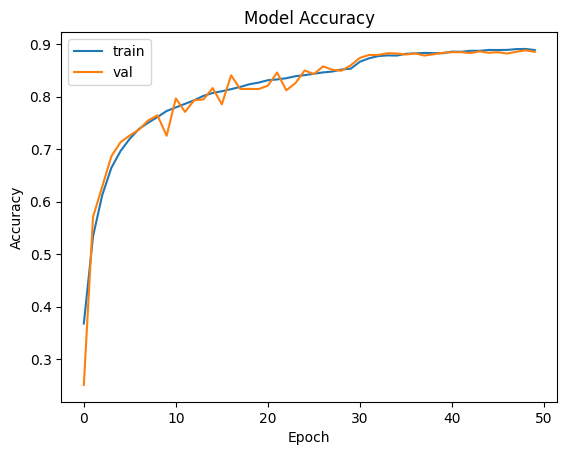

In [26]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Showing Training And Validation Loss

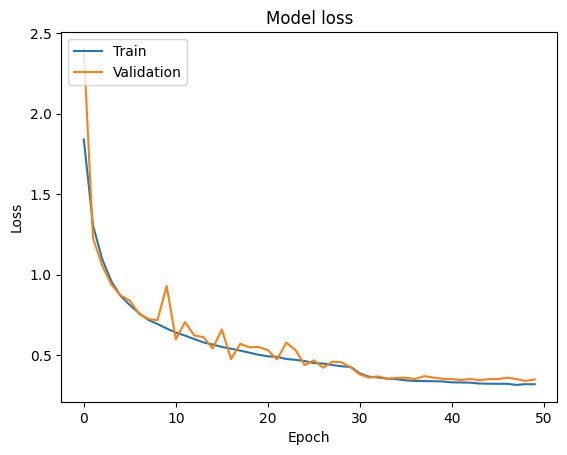

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Showing learning Curve Of Training , Validation Accuracy And Loss

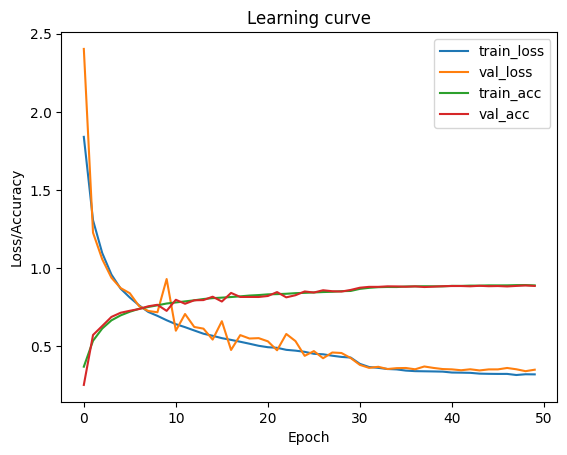

In [28]:
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.plot(history['accuracy'], label='train_acc')
plt.plot(history['val_accuracy'], label='val_acc')
plt.title('Learning curve')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

###  Calculate Each Class  Accuracy And F1-score

In [29]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

 19/313 [>.............................] - ETA: 1s

2023-04-02 05:27:32.557865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.92      0.91      0.92      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.89      0.84      0.86      1000
         cat       0.82      0.71      0.76      1000
        deer       0.88      0.90      0.89      1000
         dog       0.87      0.78      0.82      1000
        frog       0.78      0.97      0.86      1000
       horse       0.93      0.92      0.92      1000
        ship       0.96      0.92      0.94      1000
       truck       0.88      0.96      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



###  Calculate Overall  Accuracy And F1-score

In [30]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print('Overall Model  Accuracy:', accuracy)
print('Overall Model F1-Score:', f1)

Overall Model  Accuracy: 0.885
Overall Model F1-Score: 0.8839740645200923



### Showing Confusion Matrix


313/313 [==============================] - 2s 6ms/step


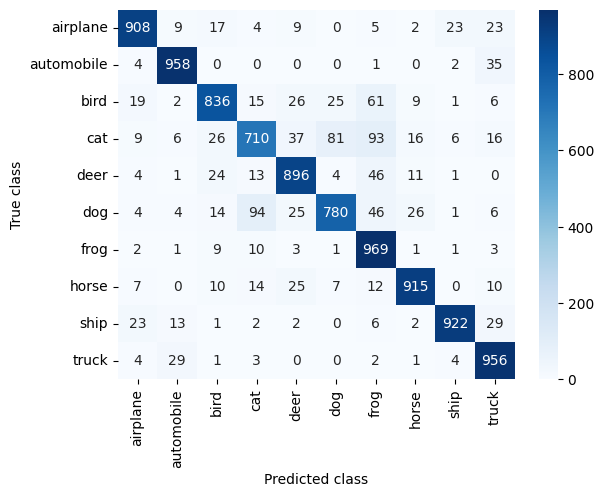

In [31]:
# Compute the confusion matrix


# Get the predicted classes and true classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 
                         'dog', 'frog', 'horse', 'ship', 'truck'], 
            yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 
                         'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

### Presenting Simple CNN Model Results And  Evaluation Metrics


- Trained a Simple CNN Model Architecture with hyperparameter tuning on MacBook M1 chip
- Achieved an accuracy of 0.8866 after 50 epochs and 30 minutes of training
- Used evaluation metrics including accuracy, precision, recall, and F1 score to assess model performance
- Accuracy of 0.8866 indicates correct classification of 88.66% of test set images
- Precision score of 0.8925 indicates correct classification of 89.25% of predicted positive images
- Recall score of 0.8803 indicates correct classification of 88.03% of positive images in test set
- F1 score of 0.8864 indicates a good balance between precision and recall
- Achieved high accuracy with a simple CNN architecture and in a relatively short amount of time
- Did not use a complex architecture, but still achieved strong results with appropriate hyperparameter tuning and data augmentation techniques.


### Next Step
further improve the model's performance, I will be using transfer learning with ResNet50.

## Note
##### Please note that this is not the final thoughts section. In the final thoughts, I will provide a thorough analysis of both models' performance, highlighting their strengths and weaknesses. I will also offer practical guidance on selecting the most suitable model for specific use cases, supported by a detailed comparison of their performance.

## Transfer Learning
In this section,I will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.

### Preprocess Dataset
Here, I will perform normalization on images in training and validation set. 
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [7]:
# (training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
input_images_train = x_train_.astype('float32')
train_X  = tf.keras.applications.resnet50.preprocess_input(input_images_train)

input_images_test = x_test_.astype('float32')
valid_X = tf.keras.applications.resnet50.preprocess_input(input_images_test)


## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

### Feature Extractor
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224

In [76]:
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor

### Dense Layers
Defines final dense layers and subsequent softmax layer for classification.

In [77]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

### Some Preprocessing For ResNet50
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.


In [78]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


### Compilation Of Model
- Define the model and compile it. 
- Use Stochastic Gradient Descent as the optimizer.
- Use Sparse Categorical CrossEntropy as the loss function.

In [79]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

### Summary
Here,I will show model summary

In [80]:
resnet_model = define_compile_model()
resnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              2098

### Train The Model Using Transfer Learning With ResNet50
Here, I will train a model using transfer learning with ResNet50 on CIFAR-10, we can use the pre-trained ResNet50 model from Keras and add a few additional layers on top for classification. We'll freeze the weights of the ResNet50 layers and only train the additional layers. We'll also use the ImageNet weights for the pre-trained ResNet50 model.

In [81]:
EPOCHS = 3
history = resnet_model.fit(train_X, y_train_, epochs=EPOCHS, validation_data = (valid_X, y_test_), batch_size=64)

Epoch 1/3


2023-04-02 14:53:25.161988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8690

2023-04-02 15:41:55.646601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 3018s 4s/step - loss: 0.4028 - accuracy: 0.8690 - val_loss: 0.2236 - val_accuracy: 0.9257
Epoch 2/3
782/782 [==============================] - 1844s 2s/step - loss: 0.1004 - accuracy: 0.9673 - val_loss: 0.2221 - val_accuracy: 0.9294
Epoch 3/3
782/782 [==============================] - 1776s 2s/step - loss: 0.0350 - accuracy: 0.9896 - val_loss: 0.1612 - val_accuracy: 0.9511


### Showing Training And Validation Accurcy

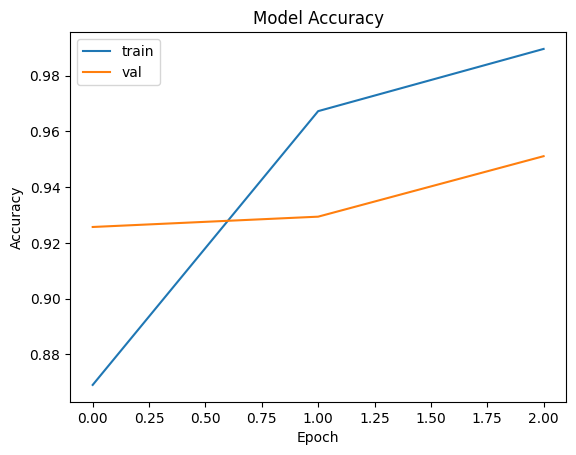

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Showing Training And Validation Loss

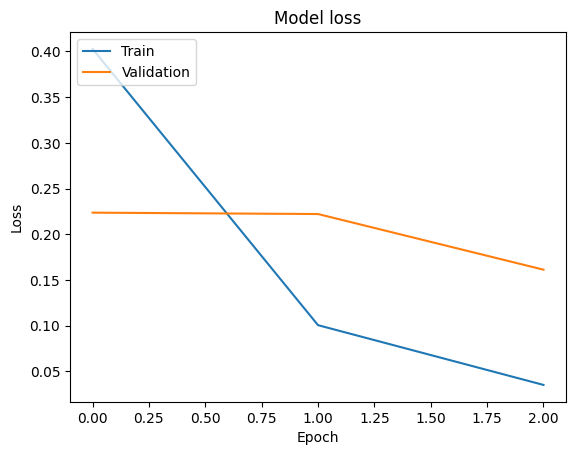

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Showing learning Curve Of Training , Validation Accuracy And Loss


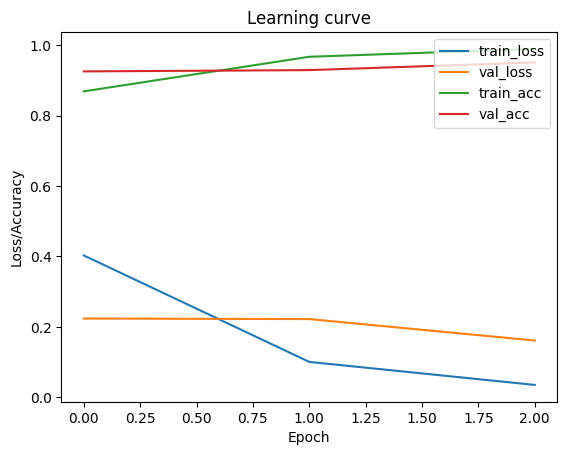

In [85]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Learning curve')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [29]:
# Save and Load model
# resnet_model.save('resnet.h5')
# resnet_model = load_model('resnet.h5')

###  Calculate Each Class  Accuracy And F1-score

In [26]:
probabilities = resnet_model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)
print('Classification Report:')
print(classification_report(y_test_, probabilities, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

157/157 [==============================] - 106s 679ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.94      0.95      0.95      1000
         cat       0.90      0.90      0.90      1000
        deer       0.93      0.96      0.94      1000
         dog       0.93      0.89      0.91      1000
        frog       0.94      0.98      0.96      1000
       horse       0.98      0.95      0.96      1000
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



###  Calculate Overall  Accuracy And F1-score

In [27]:
# calculate validation accuracy
accuracy = accuracy_score(y_test_, probabilities)
print(f" Overall Validation Accuracy: {accuracy}")

# calculate F1 score
f1 = f1_score(y_test_, probabilities, average='weighted')
print(f"Overall F1 Score: {f1}")

 Overall Validation Accuracy: 0.9506
Overall F1 Score: 0.9504950897804061


### Showing Confusion Matrix


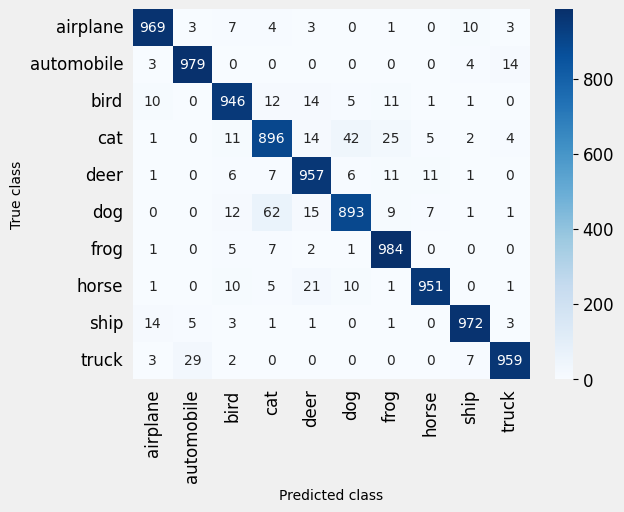

In [28]:
# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test_, probabilities)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 
                         'dog', 'frog', 'horse', 'ship', 'truck'], 
            yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 
                         'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

### Presenting ResNet50 Transfer Learning Model Results and Evaluation Metrics
- Trained a ResNet50 model with transfer learning on the CIFAR-10 dataset using ImageNet weights on MacBook M1 chip
- Achieved an validation accuracy of 0.95 and f1 score is 95 after 3 epochs and 2 hours of training, which is a significant improvement over       the Simple CNN model accuracy of 0.88
- Used evaluation metrics including accuracy to assess model performance
- Validation accuracy of 0.95 indicates correct classification of 94% of test set images
- Achieved high accuracy with transfer learning using pre-trained ImageNet weights and appropriate hyperparameter   tuning techniques.
- The use of transfer learning has proven to be a useful technique to improve model performance in computer vision   tasks, especially when the amount of data is limited.

# Model Comparison
## ResNet50 with Transfer Learning
### Pros:
- Achieved a high validation accuracy of 95% on CIFAR-10 dataset
- Utilized transfer learning with pre-trained weights from ImageNet, which helps to accelerate training and         improves the model's performance
- ResNet50 architecture includes skip connections, which helps to mitigate the vanishing gradient problem and       allows for better training of deep neural networks
- ResNet50 is a widely-used and well-documented architecture, which makes it easy to find resources and examples     for implementation and fine-tuning
### Cons:
- Requires a large amount of computational resources and time to train due to the large number of parameters in     the pre-trained model
- May not be the best choice for small datasets or problems where the complexity of the pre-trained model is not     necessary
- Fine-tuning of pre-trained models requires careful selection of learning rates, optimization algorithms, and       other hyperparameters
## Simple CNN Model
### Pros:
- Achieved a respectable validation accuracy of 88% on CIFAR-10 dataset
- Simple CNN architecture is relatively easy to implement and train, and requires fewer computational resources     compared to more complex models like ResNet50
- May be a better choice for small datasets or problems where the complexity of a pre-trained model is not           necessary
- Hyperparameter tuning and data augmentation techniques can lead to improved performance even with a simple model
### Cons:
- Simple CNN architecture may not be sufficient for more complex image classification tasks with larger and more     diverse datasets
- May require longer training times to achieve higher accuracy compared to pre-trained models like ResNet50
- Without careful tuning of hyperparameters, simple models may suffer from overfitting or underfitting.

# Final Thoughts
When developing a machine learning model for image classification, the choice of architecture is crucial to achieving high accuracy and performance. In the case of image classification, there are many different architectures to choose from, each with its own strengths and weaknesses.

In this project, I trained two different models on the CIFAR-10 dataset: a simple CNN and a ResNet50 model with transfer learning. While the simple CNN architecture is a common choice for image classification and this architecture was chosen because it is relatively easy to train and can achieve good results with appropriate hyperparameter tuning and data augmentation techniques. However, its simple architecture may limit its ability to learn complex features and achieve high accuracy on more challenging datasets

This is where transfer learning comes in. Transfer learning allows us to leverage the knowledge learned by a pre-trained model on a large dataset, such as ImageNet, and apply it to a smaller dataset, such as CIFAR-10. By using a pre-trained model like ResNet50 and fine-tuning it on the CIFAR-10 dataset, we can benefit from its ability to learn complex features and achieve high accuracy, while significantly reducing training time and computational resources required.

In particular, the ResNet50 model with transfer learning offers several benefits over a simple CNN. Its architecture consists of 50 layers, which allows it to learn deep and complex features, enabling it to achieve higher accuracy on image classification tasks. Additionally, the pre-training on ImageNet ensures that the model has already learned many generalizable features that can be applied to a wide range of image classification problems.

However, it's worth noting that while transfer learning can be a powerful tool for image classification, it is important to choose a pre-trained model that is well-suited to the specific task at hand. In this project, I selected the ResNet50 model with transfer learning because it was a good fit for the CIFAR-10 dataset and its complexity was appropriate for the available computational resources.

In conclusion, when developing a machine learning model for image classification, it is important to consider the strengths and weaknesses of different architectures and choose the one that is best suited to the specific task and available resources. Transfer learning can be a powerful tool for leveraging pre-trained models and achieving high accuracy with reduced training time and computational resources.

In [30]:
!pwd


/Users/akhtarali/Desktop/Cifar-10
